# NLP- Challange (part 4)

## Jigsaw Multilingual Challange.

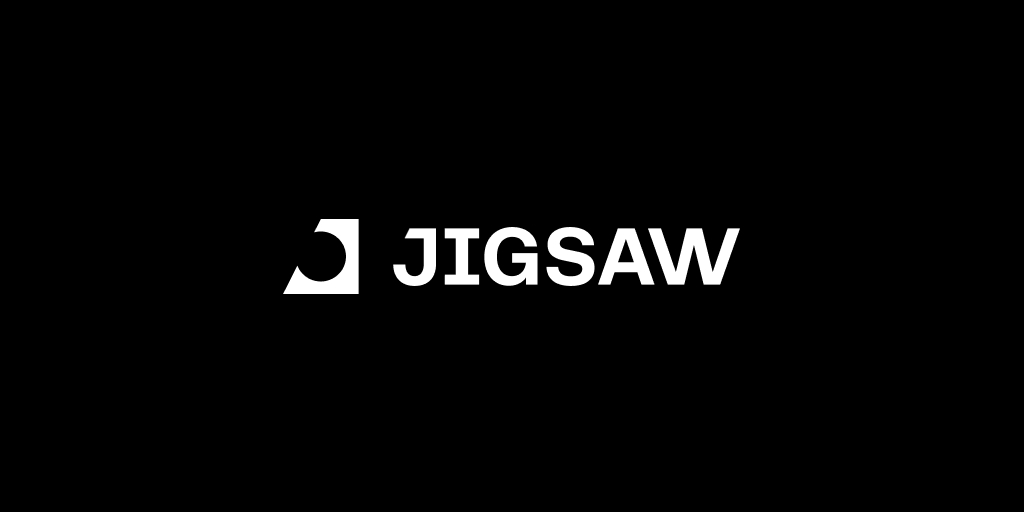

[**Jigsaw**](https://jigsaw.google.com/) is a unit of Google, which is aim towards "Using technology to make internet safer"<br/>

"Disinformation campaigns are becoming more sophisticated, but so are the countermeasures."                                                                                    - Jigsaw 
                                                                                    
Jigsaw use forecasting technology to predicts threat in internet and solves it to maintaining sanity of internet.

This challange by **jigsaw** is aimed towards finding toxic comments which could destabalize internet.<br/>
We are given training, testing, validation which contains sentences in different languages and they are classified in one of the<br/>
following category 

1. toxic 
2. severe_toxic
3. obscence
4. threat
5. insult
6. identiy_threat
7. none (all columns zero)


we will see the code using tensorflow and then using hugging face.

In [ ]:
import os, time
import pandas
import tensorflow as tf
import tensorflow_hub as hub
from kaggle_datasets import KaggleDatasets
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


# We'll use a tokenizer for the BERT model from the modelling demo notebook.
!pip install bert-tensorflow
from bert.tokenization import FullTokenizer

print(tf.version.VERSION)

# LOok inTo tHe dAta

In [ ]:
PATH = "../input/jigsaw-multilingual-toxic-comment-classification"

#herre is am using data from bert_multi dataset which has 'vocab.txt' and other required for bert.
# https://www.kaggle.com/kivlichangoogle/bert-multi
BERT_PATH = "../input/bert-multi/bert_multi_from_tfhub"

#training data
train1 = pd.read_csv(f"{PATH}/jigsaw-toxic-comment-train.csv")

#we will use only train1 data for now 
# train2 = pd.read_csv(f"{PATH}/jigsaw-unintended-bias-train.csv")

test = pd.read_csv(f"{PATH}/test.csv")
validation = pd.read_csv(f"{PATH}/validation.csv")  

#sample submission
sample = pd.read_csv(f"{PATH}/sample_submission.csv")

print("train 1 : ",train1.shape)
print("test : ",test.shape)
print("validation: ",validation.shape)
print("samaple : ", sample.shape)

In [ ]:
train1.head()

In [ ]:
test.head()

There are four basic steps performs while making BERT model.
1. tokenizing the words and converting it to ids.
2. adding bert layer to keras model
3. training data
4. making prediction

In [ ]:
def get_tokenizer(bert_path = BERT_PATH):
    
    #load bert_layer from BERT_PATH
    bert_layer = tf.saved_model.load(bert_path)
    bert_layer = hub.KerasLayer(bert_layer,trainable=False)
    
    #get the vocab file required for tokenizer
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tf.gfile = tf.io.gfile
    
    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = get_tokenizer()

In [ ]:
#demo of what tokenizer actually does
print(train1.comment_text[0])

tokens = tokenizer.tokenize(train1.comment_text[0])
print(tokens)

token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

In [ ]:
#maximum words allowed in single sentence including [CLS] AND [SEP]
max_length = 128

def comment_to_ids(comment,tokenizer=tokenizer,MAX_LEN = max_length):
    
    #tokenize the  sentence
    tokens = tokenizer.tokenize(comment)
    
    #truncate the sentence
    if len(tokens) > (MAX_LEN - 2): # -2 because [CLS] ans [SEP] are 2 default tokens to add
        tokens = tokens[:(MAX_LEN -2)]
    
    token_ids = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens+["[SEP]"])
    
    input_mask = [1] * len(token_ids)
    
    #padding sequence
    padding_len = MAX_LEN - len(token_ids)
    
    token_ids.extend([0] * padding_len)
    input_mask.extend([0] * padding_len)
    
    segment_ids = [0] * MAX_LEN
    
    return token_ids, input_mask, segment_ids

In [ ]:
%%time
def convert_comments_to_ids(data,MAX_LEN = max_length,text_label="comment_text"):
    
    data["input_ids"], data["input_mask"],data["segment_ids"]  = zip(*data[text_label].apply(comment_to_ids))
    
    return data

train_ids_df = convert_comments_to_ids(train1)


#need some help here 
#as comment_to_ids is returning three values
#I have written it like this zip(*data[text_label].apply(comment_to_ids))
# so Is this the best practice or there is any othr way to do it.

In [ ]:
%%time
# converting various toxic label to one column toxicity
def get_toxic_label(comment):
    toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
    
    if comment[toxic_labels].any():
        return 1 
    else:
        return 0

train_ids_df["Toxicity"] = train_ids_df.apply(get_toxic_label,axis=1)

In [ ]:
X = train_ids_df[["input_ids","input_mask","segment_ids"]]
y = train_ids_df["Toxicity"]

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,shuffle=True)

## TPU Config

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

## Bert Model

In [ ]:
BERT_GCS_PATH = KaggleDatasets().get_gcs_path('bert-multi')
BERT_GCS_PATH_SAVEDMODEL = BERT_GCS_PATH + "/bert_multi_from_tfhub"

In [ ]:
def bert_model(bert_path=BERT_GCS_PATH_SAVEDMODEL,MAX_LEN=max_length,trainable_bert=True):
    
    input_word_ids = tf.keras.layers.Input(shape=(MAX_LEN,),dtype=tf.int32, name="input_word_ids")
    input_mask_ids = tf.keras.layers.Input(shape=(MAX_LEN,),dtype=tf.int32, name="input_mask_ids")
    segment_ids = tf.keras.layers.Input(shape=(MAX_LEN,),dtype=tf.int32, name="segment_ids")
    
    bert_layer = tf.saved_model.load(bert_path)
    bert_layer = hub.KerasLayer(bert_path,trainable=trainable_bert)
    
    pooled_output,_ = bert_layer([input_word_ids,input_mask_ids,segment_ids])
    
    output = tf.keras.layers.Dense(32, activation='relu')(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(output)
    
    model = tf.keras.Model(inputs ={"input_word_ids":input_word_ids,
                                    "input_mask_ids":input_mask_ids,
                                    "segment_ids":segment_ids},outputs=output)
    
    return model

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(((X_train["input_ids"],X_train["input_mask"],X_train["segment_ids"]),y_train))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )
valid_dataset = (
     tf.data.Dataset
    .from_tensor_slices(((X_val["input_ids"],X_val["input_mask"],X_val["segment_ids"]),y_val))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
with strategy.scope():
    bert_ = bert_model()

    # Compile the model. Optimize using stochastic gradient descent.
    bert_.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
        metrics=[tf.keras.metrics.AUC()])

bert_.summary()

In [ ]:
history = bert_.fit(
    # Set steps such that the number of examples per epoch is fixed.
    # This makes training on different accelerators more comparable.
    train_dataset, steps_per_epoch=4000/strategy.num_replicas_in_sync,
    epochs=5, verbose=1, validation_data=valid_dataset,
    validation_steps=100)

# Hugging Face

In [ ]:
import transformers
from tokenizers import BertWordPieceTokenizer

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

#this function creates three files given in output
tokenizer.save_pretrained('.')

fast_tokenizer = BertWordPieceTokenizer('vocab.txt',lowercase=False)
fast_tokenizer

In [ ]:
#this code does the tokenizing part and return ids
def fast_encode(texts, tokenizer, chunk_size=256, MAX_LEN=max_length):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    #truncating
    tokenizer.enable_truncation(max_length=MAX_LEN)
    
    #padding
    tokenizer.enable_padding(max_length=MAX_LEN)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
%%time
X = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=max_length)
y = train1["Toxicity"]

In [ ]:
x_train,x_valid,y_test,y_valid = train_test_split(X,y,test_size=0.2,shuffle=0.2)

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
def bert_model_2(transformer, MAX_LEN=max_length):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    output = tf.keras.layers.Dense(32, activation='relu')(cls_token)

    out = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    
    return model

In [ ]:
with strategy.scope():
    
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    
    bert_ = bert_model_2(transformer_layer)

    # Compile the model. Optimize using stochastic gradient descent.
    bert_.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
        metrics=[tf.keras.metrics.AUC()])

bert_.summary()

In [ ]:
history2 = bert_.fit(
    # Set steps such that the number of examples per epoch is fixed.
    # This makes training on different accelerators more comparable.
    train_dataset, steps_per_epoch=4000/strategy.num_replicas_in_sync,
    epochs=5, verbose=1, validation_data=valid_dataset,
    validation_steps=100)

It shows that tokenization in hugging face is superfast and <br/>
loading and training transformer is quit simple.